In [1]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

np.random.seed(0)

# (R, LOS)
# R = expected number of reservations per day
# LOS = length of stay
n = 500 # number of simulated days
rooms = 5
january = (15 * rooms / 50, 2)
february = (20 * rooms / 50, 4)
march = (25 * rooms / 50, 4) 
april = (10 * rooms / 50, 2)
may = (5 * rooms / 50, 1.5)
june = (10 * rooms / 50, 2)
july = (15 * rooms / 50, 4)
august = (25 * rooms / 50, 4)
september = (15 * rooms / 50, 2)
october = (5 * rooms / 50, 1.5)
november = (5 * rooms / 50, 1.5)
december = (15 * rooms / 50, 2)

# Parameter of the exponential distribution
s = 15
months = {
    "january": (january, 31),
    "february": (february, 28),
    "march": (march, 31),
    "april": (april, 30),
    "may": (may, 31),
    "june": (june, 30),
    "july": (july, 31),
    "august": (august, 31),
    "september": (september, 30),
    "october": (october, 31),
    "november": (november, 30),
    "december": (december, 31),
}


In [2]:
days_of_week_req = {"monday":2/3,
                "tuesday":0.5,
                "wednesday":0.5,
                "thursday":4/3,
                "friday": 1.5,
                "saturday": 2,
                "sunday": 1.5}

days_of_week_los = {
                "monday": 1.5,
                "tuesday": 1,
                "wednesday": 1,
                "thursday": 2,
                "friday": 1,
                "saturday": 0.5,
                "sunday": 2/3,
            }

In [3]:
days_of_week_req_rates = np.array([2 / 3, 0.5, 0.5, 4 / 3, 1.5, 2, 1.5])
days_of_week_req_rates = np.tile(days_of_week_req_rates, int(np.ceil(730 / 7)))[:730]

mesi = []
for month in months:
    mese = [months[month][0][0]] * months[month][1]
    mesi.extend(mese)
mesi = np.array(mesi*2)

request_rates = mesi * days_of_week_req_rates

In [5]:
days_of_week_los_rates = np.array([1.5, 1, 1, 2, 1.5, 0.5, 2/3])
days_of_week_los_rates = np.tile(days_of_week_los_rates, int(np.ceil(730 / 7)))[:730]

mesi = []
for month in months:
    mese = [months[month][0][0]] * months[month][1]
    mesi.extend(mese)
mesi = np.array(mesi * 2)

los_rates = mesi * days_of_week_los_rates


In [65]:
column_week = np.array(
    ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
)
column_week = np.tile(column_week, int(np.ceil(730 / 7)))[:730]

column_month = []
for month in months:
    mese = [month] * months[month][1]
    column_month.extend(mese)
column_month = column_month * 2

SST_month = []
for month in months:
    SST_month.extend(list(range(months[month][1])))
SST_month = SST_month * 2


In [70]:
def create_dataset(requests_lambda, los_lambda, lead_time_lambda, n):
    requests = np.random.poisson(lam=requests_lambda, size=n)
    n_of_requests = np.sum(requests)
    if type(requests_lambda) is not int:
        LOS = []
        for index, daily_requests in enumerate(requests):
            daily_los = np.random.poisson(lam=los_lambda[index], size=daily_requests)
            LOS.extend(daily_los)
        LOS = np.array(LOS)
    else:
        LOS = np.random.poisson(lam=los_lambda, size=n_of_requests)
    LOS[LOS == 0] = 1
    lead_time = np.random.exponential(scale=lead_time_lambda, size=n_of_requests)
    lead_time[lead_time < 0] = 0
    bookings = []
    counter = 0
    for index, daily_requests in enumerate(requests):
        for request in range(daily_requests):
            booking = {
                "RT": index - lead_time[counter],
                "LOS": int(LOS[counter]),
                "LT": int(lead_time[counter]),
                "SST": int(index),
                "SST_month": SST_month[index],
                "days": list(
                    range(
                        int(index),
                        int(index + LOS[counter]),
                    )
                ),
                "day_of_week": column_week[index],
                "month": column_month[index]
            }
            counter += 1
            bookings.append(booking)

    df = pd.DataFrame(bookings)
    df.sort_values(by="RT", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


In [71]:
train_df = create_dataset(request_rates, los_rates, s, n=730)
test_df = create_dataset(request_rates[:365], los_rates[:365], s, n=365)

In [72]:
train_df


,RT,LOS,LT,SST,SST_month,days,day_of_week,month
0,-42.112534,1,59,17,17,[17],thursday,january
1,-38.666326,3,90,52,21,"[52, 53, 54]",thursday,february
2,-35.642756,1,45,10,10,[10],thursday,january
3,-34.337982,1,61,27,27,[27],sunday,january
4,-32.416444,6,77,45,14,"[45, 46, 47, 48, 49, 50]",thursday,february
...,...,...,...,...,...,...,...,...
1156,709.999408,4,4,714,15,"[714, 715, 716, 717]",monday,december
1157,711.924644,2,3,715,16,"[715, 716]",tuesday,december
1158,712.511861,1,13,726,27,[726],saturday,december
1159,720.614479,1,6,727,28,[727],sunday,december


In [73]:
train_df = pd.get_dummies(train_df, columns=["month", "day_of_week"])
test_df = pd.get_dummies(test_df, columns=["month", "day_of_week"])


In [ ]:
# yearly_requests = []
# years = 2
# counter = 0
# for year in range(years):
#     for month in months:
#         monthly_requests = create_dataset(
#             months[month][0][0], months[month][0][1], s, n=months[month][1]
#         )
#         monthly_requests["month"] = month
#         monthly_requests["SST_month"] = monthly_requests.SST.copy()
#         monthly_requests[["SST","RT"]] += counter
#         counter += months[month][1]
#         yearly_requests.append(monthly_requests)
# train_df = pd.concat(yearly_requests)

# yearly_requests = []
# for year in range(1):
#     for month in months:
#         monthly_requests = create_dataset(
#             months[month][0][0], months[month][0][1], s, n=months[month][1]
#         )
#         monthly_requests["month"] = month
#         monthly_requests["SST_month"] = monthly_requests.SST.copy()
#         monthly_requests[["SST","RT"]] += counter
#         counter += months[month][1]
#         yearly_requests.append(monthly_requests)
# test_df = pd.concat(yearly_requests)

# train_df = pd.get_dummies(train_df, columns=["month"])
# test_df = pd.get_dummies(test_df, columns=["month"])
# train_df.reset_index(drop=True, inplace=True)
# test_df.reset_index(drop=True, inplace=True)


TypeError: 'int' object is not subscriptable

In [74]:
process_features = [
    "day -5",
    "day -4",
    "day -3",
    "day -2",
    "day -1",
    "feasible",
    "day +1",
    "day +2",
    "day +3",
    "day +4",
    "day +5",
    "arrived requests-3",
    "arrived requests-2",
    "arrived requests-1",
    "arrived requests0",
    "arrived requests1",
    "arrived requests2",
    "arrived requests3"
]

def oracle_policy(df):
    # Sets and inputs
    I = range(len(df))  # number of requests
    LOS = df.LOS.tolist()  # length of stay of request i
    RT = df.RT.tolist()  # reservation time of request i
    LT = df.LT.tolist()  # lead time of request i
    SST = [int(RT[i] + LT[i]) for i in I]  # service start time of request i
    J = range(rooms)  # rooms
    T = range(max(SST) + max(LOS))  # days

    model = gp.Model("apartment_demand")

    # Variables
    x = model.addVars(I, vtype=GRB.BINARY, name="x")
    # 1 if request i is served, 0 otherwise
    y = model.addVars(I, J, vtype=GRB.BINARY, name="y")
    # 1 if request i is assigned in room j, 0 otherwise
    z = model.addVars(I, J, T, vtype=GRB.BINARY, name="z")
    # 1 if request i is assigned in room j in day t, 0 otherwise

    # Each request can be assigned to only one room
    for i in I:
        model.addConstr(gp.quicksum(y[i, j] for j in J) == x[i])

    # All days until LOS must be occupied
    for i in I:
        for j in J:
            for t in range(LOS[i]):
                model.addConstr(z[i, j, SST[i] + t] == y[i, j])

    # A room can host only one request
    for j in J:
        for t in T:
            model.addConstr(gp.quicksum(z[i, j, t] for i in I) <= 1)

    # Objective function: maximize the number of nights accepted
    model.setObjective(gp.quicksum(x[i] * LOS[i] for i in I), GRB.MAXIMIZE)

    # Solve
    model.setParam("OutputFlag", 0)
    model.optimize()

    # Save the results
    df["accepted"] = [int(x[i].X) if x[i].X >= 0.5 else 0 for i in I]
    obj = model.ObjVal

    rooms_vector = np.zeros(max(df.SST) + max(df.LOS) + 10)
    arrived_requests = np.zeros(max(df.SST) + max(df.LOS) + 10)

    for row in range(len(df)):
        df.loc[row, process_features] = create_features(
            df.loc[row, "SST"], df.loc[row, "LOS"], rooms_vector, arrived_requests
        )

        # update arrived requests
        arrived_requests[df.loc[row, "SST"]] += 1

        # update occupied rooms
        if df.loc[row, "accepted"] == 1:
            rooms_vector[
                df.loc[row, "SST"] : df.loc[row, "SST"] + df.loc[row, "LOS"]
            ] += 1

    return df, obj

def create_features(arrival, los, rooms_vector, arrived_requests):       
    # PREVIOUS DAYS
    previous_days = []
    for previous_day in range(arrival-5, arrival):
        if previous_day < 0: previous_days.append(0)
        else: previous_days.append(rooms - rooms_vector[previous_day])
    # FEASIBILITY
    if np.all(rooms_vector[
        arrival : arrival
        + los
    ] < rooms): feasible = 1
    else:
        feasible = 0
    # ARRIVED REQUESTS
    previous_arrivals = []
    for day in range(arrival - 3, arrival+4):
        if day < 0:
            previous_arrivals.append(0)
        else:
            previous_arrivals.append(arrived_requests[day])
    return (
        *previous_days,
        feasible,
        *rooms_vector[arrival + los : arrival + los + 5] * (-1) + rooms,
        *previous_arrivals,
    )


def score(df, column_name="accepted"):
    return np.sum(
        [
            df.iloc[row][column_name] * df.iloc[row]["LOS"]
            for row in range(len(df))
        ]
    )

In [75]:
# solved_train_df = df = pd.read_csv("/Users/alessio/Documents/Tesi/bookings.csv")
# score_oracle_train = score(solved_train_df)
# print(score_oracle_train)

solved_train_df, score_oracle_train = oracle_policy(train_df.copy())
solved_test_df, score_oracle_test = oracle_policy(test_df.copy())

In [110]:
solved_train_df


,RT,LOS,LT,SST,SST_month,days,month_april,month_august,month_december,month_february,...,day +3,day +4,day +5,arrived requests-3,arrived requests-2,arrived requests-1,arrived requests0,arrived requests1,arrived requests2,arrived requests3
0,-42.112534,1,59,17,17,[17],False,False,False,False,...,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-38.666326,3,90,52,21,"[52, 53, 54]",False,False,False,True,...,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-35.642756,1,45,10,10,[10],False,False,False,False,...,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-34.337982,1,61,27,27,[27],False,False,False,False,...,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-32.416444,6,77,45,14,"[45, 46, 47, 48, 49, 50]",False,False,False,True,...,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,709.999408,4,4,714,15,"[714, 715, 716, 717]",False,False,True,False,...,3.0,3.0,5.0,3.0,7.0,4.0,1.0,0.0,0.0,1.0
1157,711.924644,2,3,715,16,"[715, 716]",False,False,True,False,...,3.0,3.0,3.0,7.0,4.0,2.0,0.0,0.0,1.0,1.0
1158,712.511861,1,13,726,27,[726],False,False,True,False,...,5.0,5.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1159,720.614479,1,6,727,28,[727],False,False,True,False,...,5.0,5.0,5.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0


In [152]:
from sklearn.model_selection import train_test_split
day_features = test_df.columns.drop(["RT", "LOS", "LT", "SST", "SST_month", "days"])
X = solved_train_df[["LT", "LOS", "SST_month"] + process_features + list(day_features)]
y = solved_train_df["accepted"]
X[day_features] = X[day_features].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=15, stratify=y, test_size=0.2
)
# X_train = solved_train_df[["LT","LOS"]+features]
# y_train = solved_train_df["accepted"]
# X_test = solved_test_df[["LT","LOS"]+features]
# y_test = solved_test_df["accepted"]


/var/folders/qg/w61l7rsj71l06c11y6x57vnw0000gn/T/ipykernel_3885/14647289.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[day_features] = X[day_features].astype(int)


In [227]:
def random_policy(row):
    p = 0.5381485249237029
    x = np.random.binomial(1, p)
    return x


def greedy_policy(row):
    return 1 if row["feasible"].iloc[0] == 1 else 0


def online_policy(
    test_df, estimator, estimator_features=["LT", "LOS", "SST_month"] + process_features
):
    arrived_requests = np.zeros(max(test_df.SST)+100)
    rooms_vector = np.zeros(max(test_df.SST) + 100)
    
    for row in range(len(test_df)):
        test_df.loc[row, process_features] = create_features(
            test_df.loc[row, "SST"], test_df.loc[row, "LOS"], rooms_vector, arrived_requests
        )

        # UPDATE ARRIVED REQUESTS
        arrived_requests[test_df.loc[row, "SST"]] += 1

        # STIMA DELLA DECISIONE
        if test_df.loc[row, "feasible"] == 1:
            prediction = estimator(np.array(test_df.loc[[row], estimator_features]))
            prediction = float(np.ravel(prediction)[0])

            if prediction < 0.5:
                test_df.loc[row, "predicted"] = 0
            else:
                test_df.loc[row, "predicted"] = 1
        else:
            test_df.loc[row, "predicted"] = 0

        # SE ACCETTATO, AGGIUNGI I GIORNI OCCUPATI
        if test_df.loc[row, "predicted"] == 1:
            rooms_vector[
                test_df.loc[row, "SST"] : test_df.loc[row, "SST"]
                + test_df.loc[row, "LOS"]
            ] += 1
        

    score = np.sum(test_df.LOS*test_df.predicted)
    return test_df, score

In [154]:
len(test_df)

576

In [193]:
test_df

,RT,LOS,LT,SST,SST_month,days,month_april,month_august,month_december,month_february,...,day +4,day +5,arrived requests-3,arrived requests-2,arrived requests-1,arrived requests0,arrived requests1,arrived requests2,arrived requests3,predicted
0,-54.172221,2,72,18,18,"[18, 19]",False,False,False,False,...,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-51.129108,2,55,4,4,"[4, 5]",False,False,False,False,...,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-49.600101,1,55,6,6,[6],False,False,False,False,...,5.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-37.850042,1,41,4,4,[4],False,False,False,False,...,5.0,5.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-32.186857,1,37,5,5,[5],False,False,False,False,...,5.0,5.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,355.195318,5,1,357,23,"[357, 358, 359, 360, 361]",False,False,True,False,...,5.0,5.0,0.0,6.0,1.0,0.0,1.0,1.0,0.0,1.0
572,355.852165,1,0,356,22,[356],False,False,True,False,...,3.0,0.0,1.0,0.0,6.0,1.0,1.0,1.0,1.0,0.0
573,356.346491,1,5,362,28,[362],False,False,True,False,...,5.0,5.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0
574,359.075705,2,0,360,26,"[360, 361]",False,False,True,False,...,5.0,5.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0


In [192]:
a, b = online_policy(test_df=test_df.copy(), estimator=random_policy)
print(f"Performance of random policy: {b}/{score_oracle_test}")


Performance of random policy: 540.0/906.0


In [200]:
a, b = online_policy(
    test_df=test_df.copy(),
    estimator=greedy_policy
)
print(f"Performance of greedy policy: {b}/{score_oracle_test}")


Performance of greedy policy: 824.0/906.0


In [ ]:
# Proviamo ad addestrare una regressione logistica pesata
import statsmodels.api as sm
df = pd.read_csv("/Users/alessio/Documents/Tesi/bookings.csv")
errors_loaded = np.load("losses.npy")
df["weight"] = errors_loaded
frames = [
    df[df["weight"] == 1],
    df[df["weight"] == 2],
    df[df["weight"] == 2],
    df[df["weight"] == 3],
    df[df["weight"] == 3],
    df[df["weight"] == 3],
    df[df["weight"] == 4],
    df[df["weight"] == 4],
    df[df["weight"] == 4],
    df[df["weight"] == 4],
    df[df["weight"] == 5],
    df[df["weight"] == 5],
    df[df["weight"] == 5],
    df[df["weight"] == 5],
    df[df["weight"] == 5],
]
weighted_df = pd.concat(frames)
X_const = weighted_df.drop(["days", "accepted", "weight", "RT"], axis=1)
X_const = sm.add_constant(X_const)
y = weighted_df["accepted"]
logit_model = sm.Logit(y, X_const)
result = logit_model.fit(maxiter=100)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.456506
         Iterations 65
                           Logit Regression Results                           
Dep. Variable:               accepted   No. Observations:                  922
Model:                          Logit   Df Residuals:                      900
Method:                           MLE   Df Model:                           21
Date:                Fri, 05 Sep 2025   Pseudo R-squ.:                  0.3398
Time:                        19:37:40   Log-Likelihood:                -420.90
converged:                       True   LL-Null:                       -637.50
Covariance Type:            nonrobust   LLR p-value:                 1.217e-78
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -37.5664   2.29e+15  -1.64e-14      1.000   -4.48e+15    4.48e+15
LOS 

In [ ]:
test_df_const = sm.add_constant(test_df)
weighted_logit_features = ["const", "LT", "LOS", "SST"] + process_features

In [ ]:
weighted_logit_df, weighted_logit_score = online_policy(
    test_df=test_df_const.copy(), estimator=result.predict, estimator_features=weighted_logit_features
)
print(f"Performance of greedy policy: {weighted_logit_score}/{score_oracle_test}")

Performance of greedy policy: 681.0/906.0


In [157]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


accuracy:  0.7982832618025751


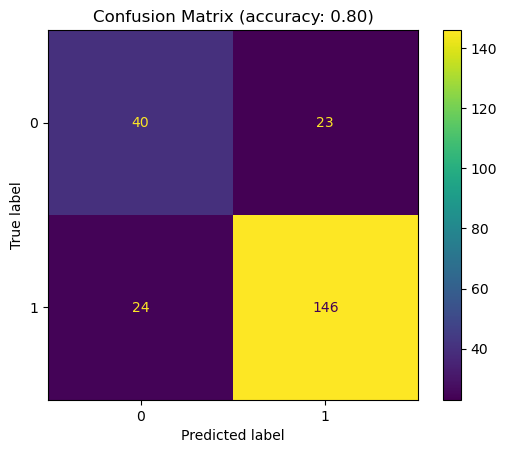

In [158]:
clf_dt = DecisionTreeClassifier(random_state=15)  
clf_dt = clf_dt.fit(X_train, y_train)

y_pred = clf_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_dt.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_dt.classes_)
disp.plot()
plt.title(f"Confusion Matrix (accuracy: {accuracy_score(y_test, y_pred):.2f})")
print("accuracy: ", accuracy_score(y_test, y_pred))

In [159]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=15, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

the best alpha is  0.0016420361247947456


<function matplotlib.pyplot.show(close=None, block=None)>

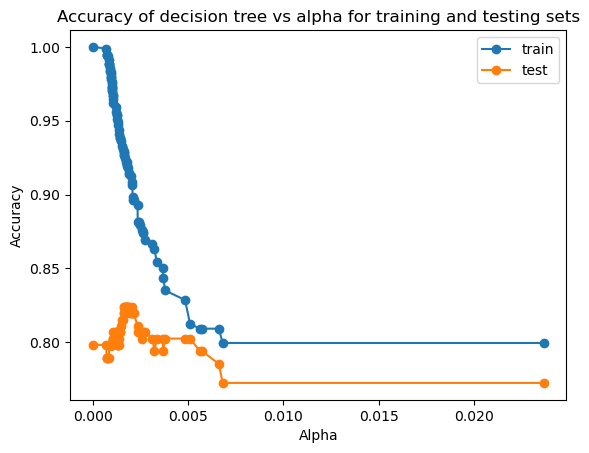

In [160]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()  # aumenta la larghezza
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of decision tree vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train")
ax.plot(ccp_alphas, test_scores, marker="o", label="test")
#ax.set_xticks(np.arange(0.001, 0.04, 0.0015))  # mostra ~20 tick

# calcolo punteggio migliore
best_index = np.argmax(test_scores)
best_alpha = ccp_alphas[best_index]
print("the best alpha is ", best_alpha)

ax.legend()
plt.show

<Axes: xlabel='tree'>

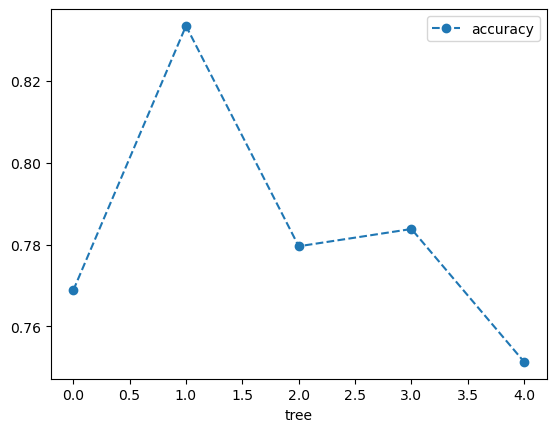

In [161]:
clf_dt = DecisionTreeClassifier(random_state=15, ccp_alpha=best_alpha)

scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df_scores = pd.DataFrame(data={"tree":range(5),"accuracy": scores})
df_scores.plot(x="tree", y = "accuracy", marker="o", linestyle = "--")

<Axes: xlabel='alpha'>

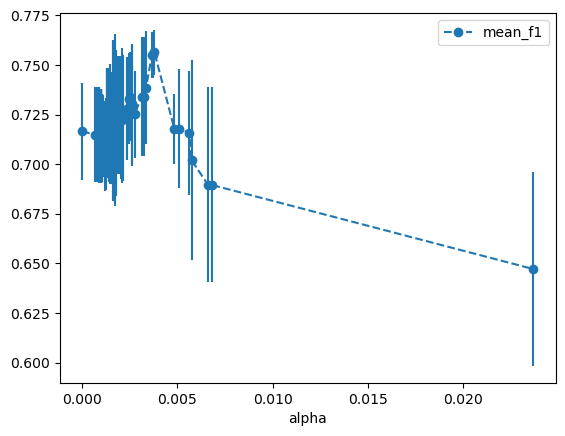

In [162]:
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=15, ccp_alpha=ccp_alpha)
    scores = cross_val_score(
        clf_dt, X_train, y_train, cv=5, scoring="f1_macro")
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values, columns=["alpha", "mean_f1", "std"])
alpha_results.plot(x="alpha", y="mean_f1", yerr="std", marker="o", linestyle="--")


In [163]:
best_index = np.argmax(alpha_results.mean_f1)
best_alpha = ccp_alphas[best_index]
best_alpha = ccp_alphas[-3]
print("best_alpha = ", best_alpha)

best_alpha =  0.006612460815047003


accuracy:  0.7854077253218884


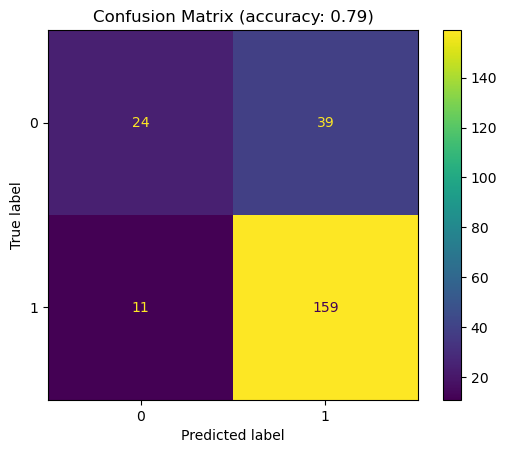

In [164]:
clf_dt_pruned = DecisionTreeClassifier(random_state=15, ccp_alpha=best_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

y_pred = clf_dt_pruned.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_dt_pruned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_dt_pruned.classes_)
disp.plot()
plt.title(f"Confusion Matrix (accuracy: {accuracy_score(y_test, y_pred):.2f})")
print("accuracy: ", accuracy_score(y_test, y_pred))


In [226]:
c, d = online_policy(
    test_df=test_df.copy(),
    estimator=clf_dt_pruned.predict,
    estimator_features=X.columns
)

print(f"Performance of greedy policy: {b}/{score_oracle_test}")
print(f"Performance of clf policy: {d}/{score_oracle_test}")


Performance of greedy policy: 824.0/906.0
Performance of clf policy: 434.0/906.0


In [166]:
# plt.figure(figsize=(15, 7.5))
# plot_tree(clf_dt_pruned, filled=True, rounded=True, class_names=["Declined", "Accepted"], feature_names=X.columns)
# plt.savefig("dt disegno.png")

In [167]:
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=15,
    # early_stopping_rounds=10,
)

clf_xgb.fit(
    X_train.values,  # Convert to numpy array
    y_train.values,  # Convert to numpy array
    verbose=True,
    eval_set=[(X_test.values, y_test.values)],  # Convert eval_set too
)


[0]	validation_0-logloss:0.50270
[1]	validation_0-logloss:0.46258
[2]	validation_0-logloss:0.43792
[3]	validation_0-logloss:0.41634
[4]	validation_0-logloss:0.40104
[5]	validation_0-logloss:0.39751
[6]	validation_0-logloss:0.38936
[7]	validation_0-logloss:0.38708
[8]	validation_0-logloss:0.38592
[9]	validation_0-logloss:0.38523
[10]	validation_0-logloss:0.38690
[11]	validation_0-logloss:0.38872
[12]	validation_0-logloss:0.38766
[13]	validation_0-logloss:0.39131
[14]	validation_0-logloss:0.38525
[15]	validation_0-logloss:0.38446
[16]	validation_0-logloss:0.38786
[17]	validation_0-logloss:0.39027
[18]	validation_0-logloss:0.38963
[19]	validation_0-logloss:0.38776
[20]	validation_0-logloss:0.38567
[21]	validation_0-logloss:0.38558
[22]	validation_0-logloss:0.38323
[23]	validation_0-logloss:0.38434
[24]	validation_0-logloss:0.38535
[25]	validation_0-logloss:0.38768
[26]	validation_0-logloss:0.38535
[27]	validation_0-logloss:0.38560
[28]	validation_0-logloss:0.38576
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [168]:
# import xgboost as xgb
# errors_loaded = np.load("losses.npy")
# y = solved_train_df["accepted"]

# X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
#     X, y, errors_loaded, random_state=15, stratify=y, test_size=0.2
# )

# clf_xgb = xgb.XGBClassifier(
#     objective="binary:logistic",
#     random_state=15,
#     # early_stopping_rounds=10,  # lo puoi riattivare se vuoi
# )

# clf_xgb.fit(
#     X_train.values,
#     y_train.values,
#     sample_weight=weight_train,  # 👈 qui aggiungi i tuoi pesi
#     eval_set=[(X_test.values, y_test.values)],
#     sample_weight_eval_set=[weight_test]



accuracy:  0.8068669527896996


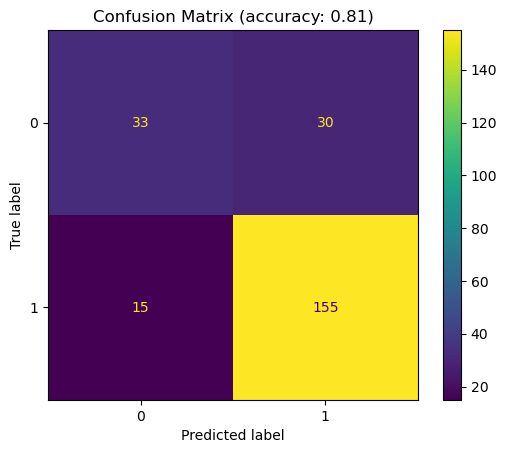

In [169]:
y_pred = clf_xgb.predict(X_test.values)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix (accuracy: {accuracy_score(y_test, y_pred):.2f})")
print("accuracy: ", accuracy_score(y_test, y_pred))

In [170]:
xgb_solved_df, xgb_score = online_policy(
    test_df=test_df.copy(), estimator=clf_xgb.predict, estimator_features=X.columns
)

print(f"Performance of greedy policy: {b}/{score_oracle_test}")
print(f"Performance of xgb policy: {xgb_score}/{score_oracle_test}")


Performance of greedy policy: 541.0/906.0
Performance of xgb policy: 796.0/906.0


In [220]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Convert to numpy arrays before training
X_train_np = X_train.values if hasattr(X_train, "values") else np.array(X_train)
y_train_np = y_train.values if hasattr(y_train, "values") else np.array(y_train)

# Ensure y is 1D
if y_train_np.ndim > 1:
    y_train_np = y_train_np.ravel()

# Your existing XGBoost classifier and parameter grid
clf_xgb = xgb.XGBClassifier(
    objective="binary:logistic", random_state=42, eval_metric="logloss"
)

param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.2, 0.5],
    "reg_alpha": [0, 0.1, 0.5, 1],
    "reg_lambda": [1, 1.5, 2, 5],
}

random_search = RandomizedSearchCV(
    clf_xgb,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1,
)

# Training with numpy arrays
random_search.fit(X_train_np, y_train_np)

print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)


Best params: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}
Best score: 0.8405231037489103


In [223]:
clf_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=15,
    # early_stopping_rounds=10,
    **random_search.best_params_,
)
clf_xgb.fit(
    np.array(X_train),  # Convert to numpy array
    np.array(y_train),  # Convert to numpy array
    verbose=True,
    eval_set=[(X_test.values, y_test.values)],
)

[0]	validation_0-logloss:0.56843
[1]	validation_0-logloss:0.55306
[2]	validation_0-logloss:0.53901
[3]	validation_0-logloss:0.52847
[4]	validation_0-logloss:0.51846
[5]	validation_0-logloss:0.50914
[6]	validation_0-logloss:0.50125
[7]	validation_0-logloss:0.49390
[8]	validation_0-logloss:0.48602
[9]	validation_0-logloss:0.47992
[10]	validation_0-logloss:0.47348
[11]	validation_0-logloss:0.46867
[12]	validation_0-logloss:0.46258
[13]	validation_0-logloss:0.45714
[14]	validation_0-logloss:0.45263
[15]	validation_0-logloss:0.44902
[16]	validation_0-logloss:0.44432
[17]	validation_0-logloss:0.44111
[18]	validation_0-logloss:0.43591
[19]	validation_0-logloss:0.43251
[20]	validation_0-logloss:0.42849
[21]	validation_0-logloss:0.42503
[22]	validation_0-logloss:0.42227
[23]	validation_0-logloss:0.41992
[24]	validation_0-logloss:0.41606
[25]	validation_0-logloss:0.41300
[26]	validation_0-logloss:0.40962
[27]	validation_0-logloss:0.40808
[28]	validation_0-logloss:0.40580
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

accuracy:  0.8154506437768241


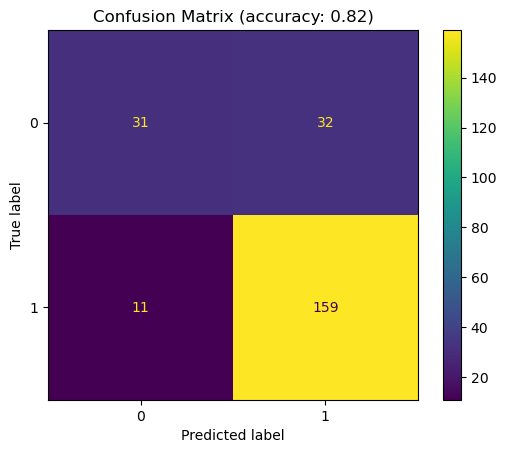

In [224]:
y_pred = clf_xgb.predict(X_test.values)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix (accuracy: {accuracy_score(y_test, y_pred):.2f})")
print("accuracy: ", accuracy_score(y_test, y_pred))


In [231]:
xgb_solved_df, xgb_score = online_policy(
    test_df=test_df.copy(),
    estimator=clf_xgb.predict,
    estimator_features=X.columns
)

print(f"Performance of greedy policy: {b}/{score_oracle_test}")
print(f"Performance of xgb policy: {xgb_score}/{score_oracle_test}")


NotFittedError: need to call fit or load_model beforehand

In [229]:
clf_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=15,
    # early_stopping_rounds=10,
    gamma=random_search.best_params_["gamma"],
    scale_pos_weight=30/17,
    reg_lambda=random_search.best_params_["reg_lambda"],
    learning_rate=random_search.best_params_["learning_rate"],
    max_depth=5,
    n_estimators = 1
)
clf_xgb.fit(X_train, y_train)

bst = clf_xgb.get_booster()

for importance_type in ("weight","gain","cover","total_gain","total_cover"):
    print("%s: ", importance_type, bst.get_score(importance_type=importance_type))

node_params = {"shape": "box", # makes the node fancy
               "style": "filled, rounded",
               "fillcolor": "#78cbe"}
leaf_params = {
    "shape": "box",  # makes the node fancy
    "style": "filled",
    "fillcolor": "#e48038",
}
plt.savefig("tree xgb2.png")
xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [177]:
import shap

explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[0])  # Per la prima predizione
shap.plots.beeswarm(shap_values)  # Panoramica globale
shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [178]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    clf_xgb,  # il tuo modello già addestrato
    X_train,  # dati di input
    features=[0, 1],  # o i nomi delle feature, es. ['lead_time', 'los', 'day +1']
    kind="average",  # oppure "individual" o "both"
)


ValueError: feature_names should not contain duplicates.

In [179]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(
    n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
clf_knn.fit(X_train, y_train)
y_pred = clf_knn.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print("accuracy: ", accuracy_score(y_test, y_pred))
print("accuracy: ", clf_knn.score(X_test, y_test, sample_weight=None))

accuracy:  0.721030042918455
accuracy:  0.721030042918455


In [180]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "n_neighbors": np.arange(1, 100),
    "weights": ["uniform", "distance"],
    "metric": ["cosine", "minkowski"],
    "p": np.arange(1, 10),
}
n_iter_search = 100
random_search_knn = RandomizedSearchCV(
    clf_knn, param_distributions=param_grid, n_iter=n_iter_search, cv=5
)
random_search_knn.fit(X_train, y_train)
print("best parameters: ", random_search_knn.best_params_)
print("best score: ", random_search_knn.best_score_)


best parameters:  {'weights': 'distance', 'p': np.int64(1), 'n_neighbors': np.int64(76), 'metric': 'minkowski'}
best score:  0.7855681487939552


accuracy:  0.7424892703862661
accuracy:  0.7424892703862661


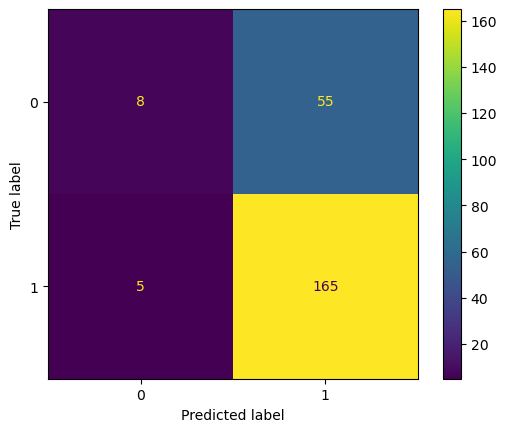

In [181]:
clf_knn = KNeighborsClassifier(
    n_neighbors=random_search_knn.best_params_["n_neighbors"],
    weights=random_search_knn.best_params_["weights"],
    algorithm="auto",
    leaf_size=30,
    p=random_search_knn.best_params_["p"],
    metric="cosine",
    metric_params=None,
    n_jobs=None,
)
clf_knn.fit(X_train, y_train)
y_pred = clf_knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print("accuracy: ", accuracy_score(y_test, y_pred))
print("accuracy: ", clf_knn.score(X_test, y_test, sample_weight=None))


In [202]:
c, d = online_policy(test_df=test_df, estimator=clf_knn.predict, estimator_features=X.columns)
print(f"Performance of clf policy: {d}/{score_oracle_test}")
print(f"Performance of greedy policy: {b}/{score_oracle_test}")


Performance of clf policy: 821.0/906.0
Performance of greedy policy: 824.0/906.0


accuracy:  0.8068669527896996


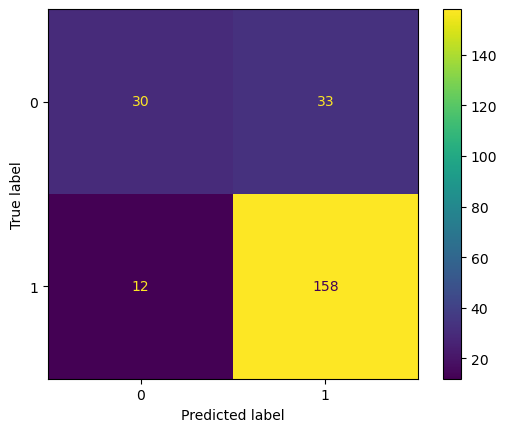

In [183]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(
    n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, verbose=0,
    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None,
    min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=-1,random_state=None,
    warm_start=False, class_weight={0: 1, 1: 5}, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
clf_rf.fit(X_train, y_train)

# print("Out of bag error: ", clf_rf.oob_score_)

y_pred = clf_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print("accuracy: ", accuracy_score(y_test, y_pred))

In [203]:
param_grid = {
    "n_estimators": [50, 75, 90, 120, 150, 200, 250, 300, 400, 500, 600],
    "max_features": np.arange(1, X.shape[1]),
}

n_iter_search = 30
random_search_rf = RandomizedSearchCV(
    clf_rf, param_distributions=param_grid, n_iter=n_iter_search, cv=5
)
random_search_rf.fit(X_train, y_train)
print("best parameters: ", random_search_rf.best_params_)
print("best score: ", random_search_rf.best_score_)


best parameters:  {'n_estimators': 50, 'max_features': np.int64(21)}
best score:  0.825446091252543


Out of bag error:  0.8071120689655172
accuracy:  0.8240343347639485


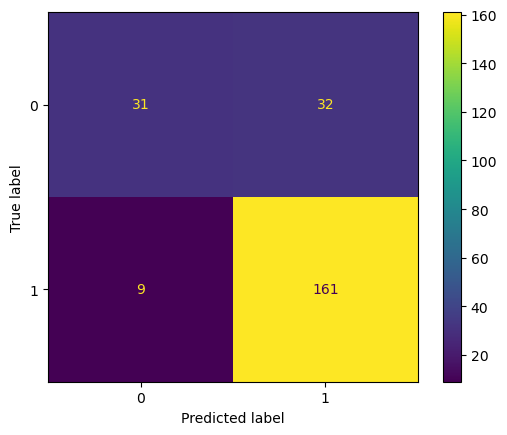

In [185]:
clf_rf = RandomForestClassifier(
    n_estimators=random_search_rf.best_params_["n_estimators"],
    max_features=random_search_rf.best_params_["max_features"],
    oob_score=True,
    n_jobs=-1,
)
clf_rf.fit(X_train, y_train)

print("Out of bag error: ", clf_rf.oob_score_)

y_pred = clf_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print("accuracy: ", accuracy_score(y_test, y_pred))


In [186]:
c, d = online_policy(test_df=test_df, estimator=clf_rf.predict, estimator_features=X.columns)
print(f"Performance of clf policy: {d}/{score_oracle_test}")
print(f"Performance of greedy policy: {b}/{score_oracle_test}")


/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does

Performance of clf policy: 578.0/906.0
Performance of greedy policy: 541.0/906.0


/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does

In [187]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=1.0,
    max_depth=1,
    random_state=0,
    validation_fraction=0.1,
).fit(X_train, y_train)
clf_gb.score(X_test, y_test)

0.8369098712446352

In [188]:
param_grid = {
    "n_estimators": [20, 30, 50, 75, 90, 120, 150, 200, 250, 300, 400, 500],
    "max_depth": np.arange(1, 10),
    "learning_rate": np.logspace(-3, 1, 10),
}

n_iter_search = 30
random_search_gb = RandomizedSearchCV(
    clf_gb, param_distributions=param_grid, n_iter=n_iter_search, cv=5
)
random_search_gb.fit(X_train, y_train)
print("best parameters: ", random_search_gb.best_params_)
print("best score: ", random_search_gb.best_score_)


best parameters:  {'n_estimators': 20, 'max_depth': np.int64(5), 'learning_rate': np.float64(0.1668100537200059)}
best score:  0.8265039232781168


0.8154506437768241
accuracy:  0.8154506437768241


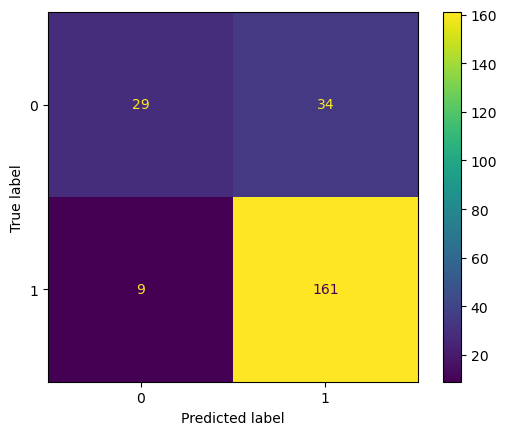

In [189]:
clf_gb = GradientBoostingClassifier(
    n_estimators=random_search_gb.best_params_["n_estimators"],
    learning_rate=random_search_gb.best_params_["learning_rate"],
    max_depth=random_search_gb.best_params_["max_depth"],
    random_state=0,
    validation_fraction=1e-10,
).fit(X_train, y_train)
print(clf_gb.score(X_test, y_test))
y_pred = clf_gb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print("accuracy: ", accuracy_score(y_test, y_pred))


In [232]:
e, f = online_policy(test_df=test_df, estimator=clf_gb.predict)
print(f"Performance of clf policy: {f}/{score_oracle_test}")
print(f"Performance of greedy policy: {b}/{score_oracle_test}")


/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


ValueError: X has 21 features, but GradientBoostingClassifier is expecting 58 features as input.

In [233]:
greedy_solved_df, greedy_score = online_policy(test_df=test_df.copy(), estimator=greedy_policy)
print(f"Performance of greedy policy: {greedy_score}/{score_oracle_test}")

dt_solved_df, dt_score = online_policy(test_df=test_df, estimator=clf_dt.predict)
print(f"Performance of dt policy: {dt_score}/{score_oracle_test}")
xgb_solved_df, xgb_score = online_policy(test_df=test_df, estimator=clf_xgb.predict)
print(f"Performance of xgb policy: {xgb_score}/{score_oracle_test}")
# svm_solved_df, svm_score = online_policy(test_df=test_df, estimator=clf_svm.predict)
# print(f"Performance of clf policy: {svm_score}/{score_solved_test_df}")
knn_solved_df, knn_score = online_policy(test_df=test_df, estimator=clf_knn.predict)
print(f"Performance of knn policy: {knn_score}/{score_oracle_test}")
rf_solved_df, rf_score = online_policy(test_df=test_df, estimator=clf_rf.predict)
print(f"Performance of rf policy: {rf_score}/{score_oracle_test}")
gb_solved_df, gb_score = online_policy(test_df=test_df, estimator=clf_gb.predict)
print(f"Performance of gb policy: {gb_score}/{score_oracle_test}")


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices